# RAPIDS & Scanpy Single-Cell RNA-seq Workflow on MnPO cells

Copyright (c) 2020, NVIDIA CORPORATION.

Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This notebook demonstrates a single-cell RNA analysis workflow that begins with preprocessing a count matrix of size `(n_gene, n_cell)` and results in a visualization of the clustered cells for further analysis.

For demonstration purposes, we use a dataset of 1.3 M brain cells with Unified Virtual Memory to oversubscribe GPU memory.

## Import requirements

In [2]:
import numpy as np
import scanpy as sc
import anndata

import time
import os, wget

import cupy as cp
import cudf

from cuml.decomposition import PCA
from cuml.manifold import TSNE
from cuml.cluster import KMeans
from cuml.preprocessing import StandardScaler

import rapids_scanpy_funcs
import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

We use the RAPIDS memory manager to enable Unified Virtual Memory management, which allows us to oversubscribe the GPU memory.

In [3]:
import rmm

rmm.reinitialize(managed_memory=True)
cp.cuda.set_allocator(rmm.rmm_cupy_allocator)

## Input data

In the cell below, we provide the path to the sparse `.h5ad` file containing the count matrix to analyze. Please see the README for instructions on how to download the dataset we use here.

To run this notebook using your own dataset, please see the README for instructions to convert your own count matrix into this format. Then, replace the path in the cell below with the path to your generated `.h5ad` file.

In [7]:

url=r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM4663167&format=file&file=GSM4663167%5F1%2DSFO%2Dsingle%2Dcell%2Ecsv%2Egz"
input_file="/temp/data/mouse_SFO/GSM4663167_1-SFO-single-cell.csv.gz"
input_csv="/temp/data/mouse_SFO/GSM4663167_1-SFO-single-cell.csv"
if not os.path.exists(input_csv):
    print('Downloading import file...')
    os.makedirs('/temp/data/mouse_SFO', exist_ok=True)
    wget.download(url,input_file)

results_file = "/temp/data/mouse_SFO/sfo_ctrl.h5ad"

In [4]:
from sh import gunzip
gunzip(input_file)

## Set parameters

In [4]:
D_R_mtx=pd.read_csv("/temp/drug_receptor_mtx.csv",index_col=0)
GPCR_type_df=pd.read_csv("/temp/GPCR_df.csv",index_col=0)

drug_list=D_R_mtx.index.to_list()
GPCR_list=["HTR1A","HTR1B","HTR1D","HTR1E","HTR2A","HTR2B","HTR2C",
"HTR3A","HTR4","HTR5A","HTR6","HTR7","DRD1","DRD2","DRD3","DRD4","DRD5",
"HRH1","HRH2","HRH3","CHRM1","CHRM2","CHRM3","CHRM4","CHRM5",
"ADRA1A","ADRA1B","ADRA2A","ADRA2B","ADRA2C","ADRB1","ADRB2"]
D_R_mtx.columns=GPCR_list

In [5]:
# marker genes
MITO_GENE_PREFIX = "mt-" # Prefix for mitochondrial genes to regress out
markers = ["CX3CR1","CLDN5","GLUL","NDRG2","PCDH15","PLP1","MBP","SATB2","SLC17A7",
"SLC17A6","GAD2","GAD1","SNAP25"] # Marker genes for visualization
#print(d_r_column_rep[1:])
markers.extend(GPCR_list)
markers = [str.upper() for str in markers]
markers.remove("HTR1E")
# filtering cells
min_genes_per_cell = 200 # Filter out cells with fewer genes than this expressed 
max_genes_per_cell = 6000 # Filter out cells with more genes than this expressed 

# filtering genes
min_cells_per_gene = 1 # Filter out genes expressed in fewer cells than this
n_top_genes = 4000 # Number of highly variable genes to retain

# PCA
n_components = 50 # Number of principal components to compute

# Batched PCA
pca_train_ratio = 0.35 # percentage of cells to use for PCA training
n_pca_batches = 10

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# k-means
k = 35 # Number of clusters for k-means

# KNN
n_neighbors = 15 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.3 
umap_spread = 1.0

In [91]:
start = time.time()

## Load and Preprocess Data

We load the sparse count matrix from an `csv` file using Scanpy. 

In [92]:
preprocess_start = time.time()

In [8]:
adata = sc.read_csv(input_csv)
adata=adata.T

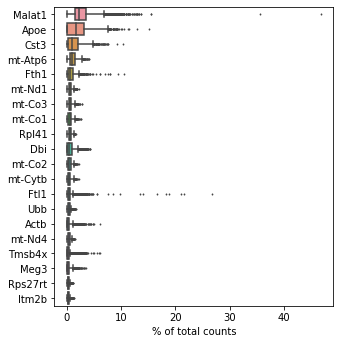

In [9]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [10]:
genes = cudf.Series(adata.var_names).str.upper()
print(genes)
from scipy import sparse

sparse_X = sparse.csr_matrix(adata.X)
adata.X = sparse_X
sparse_gpu_array = cp.sparse.csr_matrix(adata.X)

0                  XKR4
1                GM1992
2               GM37381
3                 SOX17
4                MRPL15
              ...      
22410        AC125149.3
22411        AC168977.1
22412        AC149090.1
22413    CAAA01118383.1
22414    CAAA01147332.1
Length: 22415, dtype: object


Verify the shape of the resulting sparse matrix:

In [11]:
sparse_gpu_array.shape

(7950, 22415)

And the number of non-zero values in the matrix:

In [12]:
sparse_gpu_array.nnz

24980297

In [13]:
%%time
sparse_gpu_array = rapids_scanpy_funcs.filter_cells(sparse_gpu_array, min_genes=min_genes_per_cell, max_genes=max_genes_per_cell)

CPU times: user 208 ms, sys: 68 ms, total: 276 ms
Wall time: 274 ms


Some genes will now have zero expression in all cells. We filter out such genes.

In [14]:
%%time
sparse_gpu_array, genes = rapids_scanpy_funcs.filter_genes(sparse_gpu_array, genes, min_cells=min_cells_per_gene)

CPU times: user 207 ms, sys: 11.7 ms, total: 219 ms
Wall time: 218 ms


The size of our count matrix is now reduced.

In [15]:
sparse_gpu_array.shape

(7745, 22414)

In [53]:
len(genes)

22414

In [19]:
import pandas as pd
df=genes.to_pandas()
#print(df)
#df.to_csv("../data/SFO/genes.csv")
for marker in markers:
    if not marker in df.values:
        print("%s is not included"%marker)
        markers.remove(marker)
        print("%s is removed from marker list"%marker)

CHRM5 is not included
CHRM5 is removed from marker list


In [20]:
%%time
tmp_norm = sparse_gpu_array.tocsc()
marker_genes_raw = {
    ("%s_raw" % marker): tmp_norm[:, genes[genes == marker].index[0]].todense().ravel()
    for marker in markers
}

del tmp_norm

CPU times: user 221 ms, sys: 56.5 ms, total: 277 ms
Wall time: 275 ms


### Regress out confounding factors (number of counts, mitochondrial gene expression)

We can now perform regression on the count matrix to correct for confounding factors -  for example purposes, we use the number of counts and the expression of mitochondrial genes (named starting with `mt-`).

We now calculate the total counts and the percentage of mitochondrial counts for each cell.

In [21]:
%%time
mito_genes = genes.str.startswith(MITO_GENE_PREFIX)

n_counts = sparse_gpu_array.sum(axis=1)
percent_mito = (sparse_gpu_array[:,mito_genes].sum(axis=1) / n_counts).ravel()

n_counts = cp.array(n_counts).ravel()
percent_mito = cp.array(percent_mito).ravel()

CPU times: user 13.4 ms, sys: 149 µs, total: 13.5 ms
Wall time: 11.9 ms


In [22]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

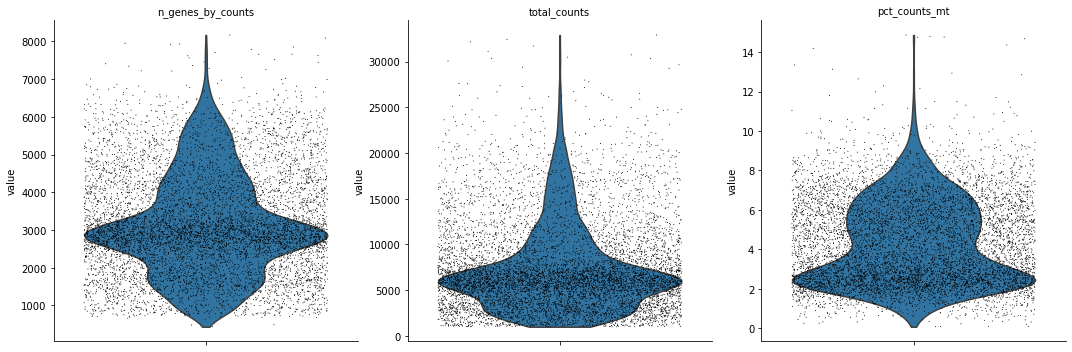

In [23]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

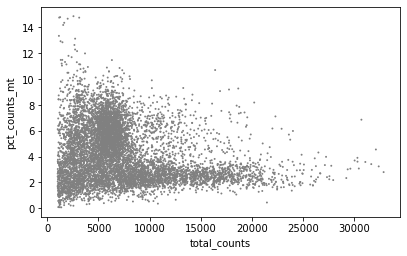

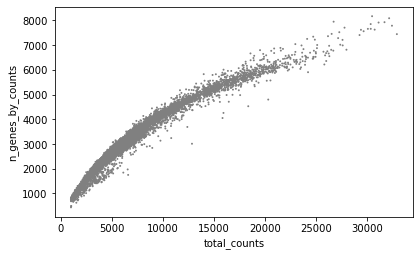

In [24]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

And perform regression:

In [25]:
%%time
sparse_gpu_array = rapids_scanpy_funcs.regress_out(sparse_gpu_array.tocsc(), n_counts, percent_mito)
del n_counts, percent_mito, mito_genes

CPU times: user 2min 58s, sys: 40.2 s, total: 3min 38s
Wall time: 3min 38s


### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations, obtaining the preprocessed count matrix.

In [26]:
%%time
mean = sparse_gpu_array.mean(axis=0)
sparse_gpu_array -= mean
stddev = cp.sqrt(sparse_gpu_array.var(axis=0))
sparse_gpu_array /= stddev
sparse_gpu_array = sparse_gpu_array.clip(a_max=10)
del mean, stddev

CPU times: user 124 ms, sys: 20 ms, total: 144 ms
Wall time: 143 ms


In [58]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time-preprocess_start))

NameError: name 'preprocess_start' is not defined

## Cluster & Visualize

We store the preprocessed count matrix as an AnnData object, which is currently in host memory. We also add the expression levels of the marker genes as observations to the annData object.

In [27]:
%%time
adata = anndata.AnnData(sparse_gpu_array.get())
adata.var_names = genes.to_pandas()
del sparse_gpu_array, genes

CPU times: user 132 ms, sys: 94.3 ms, total: 226 ms
Wall time: 224 ms


In [28]:
%%time
for name, data in marker_genes_raw.items():
    adata.obs[name] = data.get()

CPU times: user 29.3 ms, sys: 4.27 ms, total: 33.5 ms
Wall time: 32.2 ms


In [53]:
file_path="/temp/data/mouse_SFO/WT_SFO_adata.h5ad"
adata.write(file_path)
#adata = anndata.read_h5ad(file_path)

In [29]:
%%time
GPCR_df=pd.DataFrame()
for name, data in marker_genes_raw.items():
    adata.obs[name] = data.get()
    if   name[:-4] in GPCR_list:
        GPCR_df[name]=data.get()
        
GPCRdf_path="/temp/data/mouse_SFO/WT_SFO_scRNA_GPCR_raw_df.csv"
GPCR_df.to_csv(GPCRdf_path)

CPU times: user 94.6 ms, sys: 3.71 ms, total: 98.4 ms
Wall time: 235 ms


### Calculate Antipsychotics response

In [30]:
GPCR_adata=anndata.AnnData(X=GPCR_df)
print(GPCR_adata.X.shape)
#GPCR_adata.obs=pd.DataFrame(GPCR_df.index)
#GPCR_adata.var=pd.DataFrame(GPCR_df.columns)

file_path="/temp/data/mouse_SFO/WT_SFO_GPCR_adata.h5ad"
GPCR_adata.write(file_path)

(7745, 28)


In [31]:
GPCR_adata_norm=sc.pp.normalize_total(GPCR_adata,target_sum=1e4,inplace=False)['X']
dir="/temp/data/mouse_SFO"
GPCR_adata_norm_df=pd.DataFrame(GPCR_adata_norm,columns=GPCR_adata.var.index)
GPCR_adata_norm_df.to_csv(os.path.join(dir,"GPCR_adata_norm_df.csv"))

In [32]:
#sc.pp.normalize_total(GPCR_adata,target_sum=1e4)
sc.pp.neighbors(GPCR_adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs, method='rapids')


In [33]:

sc.tl.umap(GPCR_adata, min_dist=umap_min_dist, spread=umap_spread, method='rapids')

In [34]:
%%time
sc.tl.louvain(GPCR_adata, flavor='rapids')
GPCR_adata.obs['leiden'] = rapids_scanpy_funcs.leiden(GPCR_adata)


CPU times: user 73.4 ms, sys: 389 µs, total: 73.8 ms
Wall time: 72.8 ms


In [35]:
norm_df=pd.DataFrame(GPCR_adata_norm)
norm_col=[str[:-4] for str in GPCR_df.columns]
#print(norm_col)
norm_df.columns=norm_col
print(norm_df)

      HTR1A  HTR1B    HTR1D  HTR2A  HTR2B  HTR2C  HTR3A  HTR4  HTR5A  HTR6  \
0       0.0    0.0      0.0    0.0    0.0    0.0    0.0   0.0    0.0   0.0   
1       0.0    0.0      0.0    0.0    0.0    0.0    0.0   0.0    0.0   0.0   
2       0.0    0.0      0.0    0.0    0.0    0.0    0.0   0.0    0.0   0.0   
3       0.0    0.0      0.0    0.0    0.0    0.0    0.0   0.0    0.0   0.0   
4       0.0    0.0      0.0    0.0    0.0    0.0    0.0   0.0    0.0   0.0   
...     ...    ...      ...    ...    ...    ...    ...   ...    ...   ...   
7740    0.0    0.0      0.0    0.0    0.0    0.0    0.0   0.0    0.0   0.0   
7741    0.0    0.0      0.0    0.0    0.0    0.0    0.0   0.0    0.0   0.0   
7742    0.0    0.0      0.0    0.0    0.0    0.0    0.0   0.0    0.0   0.0   
7743    0.0    0.0  10000.0    0.0    0.0    0.0    0.0   0.0    0.0   0.0   
7744    0.0    0.0      0.0    0.0    0.0    0.0    0.0   0.0    0.0   0.0   

      ...  CHRM1  CHRM2  CHRM3  ADRA1A  ADRA1B  ADRA2A  ADRA2B 

In [36]:
print(GPCR_type_df[GPCR_type_df.receptor_name.isin(norm_col)])
GPCR_type_df=GPCR_type_df[GPCR_type_df.receptor_name.isin(norm_col)]

   receptor_name type
0         ADRA1A   Gq
1         ADRA1B   Gq
2         ADRA2A   Gi
3         ADRA2B   Gi
4         ADRA2C   Gi
5          ADRB1   Gs
6          ADRB2   Gs
7          CHRM1   Gq
8          CHRM2   Gi
9          CHRM3   Gq
12          DRD1   Gs
13          DRD2   Gi
14          DRD3   Gi
16          DRD5   Gs
17          HRH1   Gq
18          HRH2   Gs
19          HRH3   Gi
20         HTR1A   Gi
21         HTR1B   Gi
22         HTR1D   Gi
24         HTR2A   Gq
25         HTR2B   Gq
26         HTR2C   Gq
27          HTR4   Gs
28          HTR6   Gs
29          HTR7   Gs


In [37]:
Gs=GPCR_type_df[GPCR_type_df.type=="Gs"]["receptor_name"].values
Gi=GPCR_type_df[GPCR_type_df.type=="Gi"]["receptor_name"].values
Gq=GPCR_type_df[GPCR_type_df.type=="Gq"]["receptor_name"].values

#print(Gs)
#print(GPCR_adata_norm)
drug_list=D_R_mtx.index.to_list()
#print(drug_list)
#drug_receptor_mtx
cAMP_df=pd.DataFrame(columns=drug_list)
Ca_df=pd.DataFrame(columns=drug_list)
for drug in drug_list:
    Gs_effect=(norm_df.loc[:,Gs]/D_R_mtx.loc[drug,Gs]).sum(axis=1) #TODO ki値で割り算するときにlog換算すべきか
    Gi_effect=(norm_df.loc[:,Gi]/D_R_mtx.loc[drug,Gi]).sum(axis=1)
    Gq_effect=(norm_df.loc[:,Gq]/D_R_mtx.loc[drug,Gq]).sum(axis=1)
    cAMPmod=Gi_effect-Gs_effect #Giの阻害→cAMP上昇、Gsの阻害→cAMP低下
    Camod=-Gq_effect #Gq阻害→Ca低下
    cAMP_df[drug]=cAMPmod
    Ca_df[drug]=Camod

In [38]:
cAMP_df.index=adata.obs_names
Ca_df.index=adata.obs_names
Ca_df=Ca_df+10**(-4)
for drug in drug_list:
    adata.obs['cAMP_%s'%drug]=cAMP_df[drug]
    adata.obs['Ca_%s'%drug]=Ca_df[drug]

In [63]:
file_path="/temp/data/mouse_SFO/WT_SFO_adata.h5ad"
adata.write(file_path)

In [39]:
%%time
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs, method='rapids')

         Falling back to preprocessing with `sc.pp.pca` and default params.
CPU times: user 1min 57s, sys: 42 s, total: 2min 39s
Wall time: 9.9 s


In [40]:
%%time
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread, method='rapids')

CPU times: user 48.3 ms, sys: 148 ms, total: 196 ms
Wall time: 196 ms


In [41]:
%%time
sc.tl.louvain(adata, flavor='rapids')

CPU times: user 44.2 ms, sys: 2.86 ms, total: 47.1 ms
Wall time: 45.8 ms


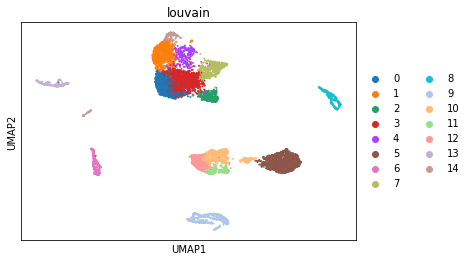

CPU times: user 272 ms, sys: 5.17 ms, total: 277 ms
Wall time: 275 ms


In [42]:
%%time
sc.pl.umap(adata, color=["louvain"])

In [43]:
%%time
adata.obs['leiden'] = rapids_scanpy_funcs.leiden(adata)

CPU times: user 47.9 ms, sys: 0 ns, total: 47.9 ms
Wall time: 46.6 ms


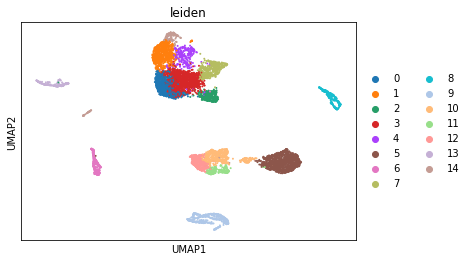

CPU times: user 287 ms, sys: 0 ns, total: 287 ms
Wall time: 285 ms


In [44]:
%%time
sc.pl.umap(adata, color=["leiden"])

In [70]:
file_path="/temp/data/mouse_SFO/WT_SFO_adata.h5ad"
adata.write(file_path)

In [45]:
adata.obs["is_clz_activated"]=np.zeros(len(adata.obs))
adata.obs["is_clz_activated"][adata.obs["cAMP_CLOZAPINE"]>10]=1
adata.obs["is_clz_activated"]=adata.obs["is_clz_activated"].astype("category")
print(sum(adata.obs["is_clz_activated"]))

340.0


In [46]:
adata.obs["is_clz_inhibited"]=np.zeros(len(adata.obs))
adata.obs["is_clz_inhibited"][adata.obs["cAMP_CLOZAPINE"]<-10]=1
adata.obs["is_clz_inhibited"]=adata.obs["is_clz_inhibited"].astype("category")
print(sum(adata.obs["is_clz_inhibited"]))

261.0


In [47]:
drug_list2=drug_list.copy()
drug_list2.remove("CLOZAPINE")
print(drug_list2)

for idx,drug in enumerate(drug_list2):
    #print(idx)
    if idx==0:
        cAMP_mean=adata.obs["cAMP_%s"%drug]
    else:
        cAMP_mean=cAMP_mean+adata.obs["cAMP_%s"%drug]
    #print(adata.obs["cAMP_%s"%drug])
cAMP_mean=cAMP_mean/len(drug_list2)
print(cAMP_mean)
adata.obs["cAMP_mean_other_than_czp"]=cAMP_mean
adata.obs["cAMP_clz_selectivity"]=adata.obs["cAMP_CLOZAPINE"]**2/cAMP_mean**2
print(sum(adata.obs["cAMP_clz_selectivity"]>1.5))

['CHLORPROMAZINE', 'FLUPHENAZINE', 'HALOPERIDOL', 'ZOTEPINE', 'RISPERIDONE', 'Quetiapine', 'ARIPIPRAZOLE', 'OLANZAPINE']
0        0.000000
1        0.000000
2        0.000000
3        0.000000
4        0.000000
          ...    
7740     0.000000
7741     0.000000
7742     0.000000
7743    58.194599
7744     0.000000
Length: 7745, dtype: float64
297


In [48]:
selectivity_threshold=1.5
adata.obs["is_clz_selective"]=np.zeros(len(adata.obs))
adata.obs["is_clz_selective"][(adata.obs["cAMP_clz_selectivity"]>1.5)&(adata.obs["cAMP_CLOZAPINE"]>0)]=1
adata.obs["is_clz_selective"]=adata.obs["is_clz_selective"].astype("category")
print(sum(adata.obs["is_clz_selective"]))

201.0


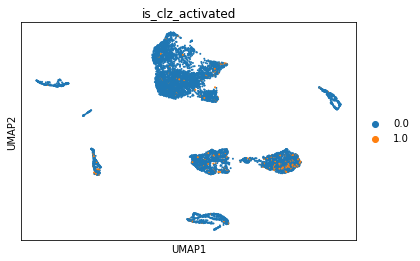

In [49]:
sc.pl.umap(adata, color=["is_clz_activated"])

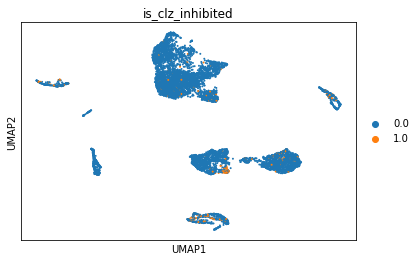

In [50]:
sc.pl.umap(adata, color=["is_clz_inhibited"])

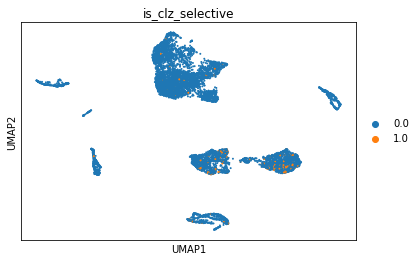

In [51]:
sc.pl.umap(adata, color=["is_clz_selective"])

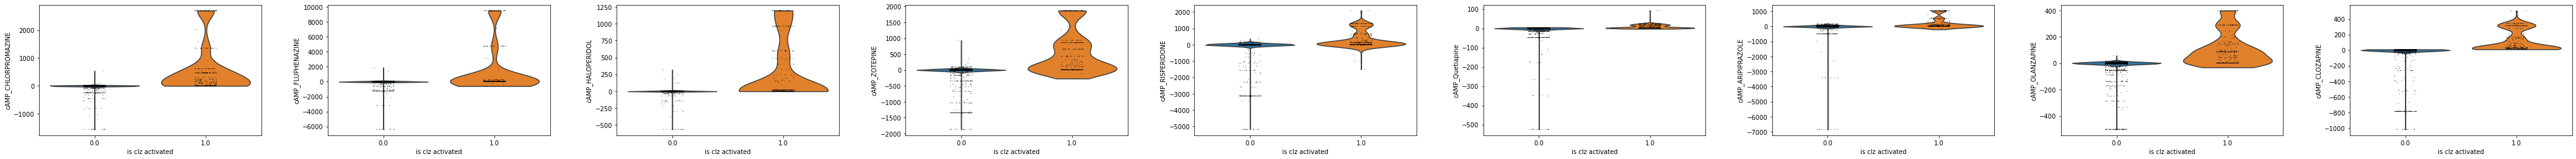

CPU times: user 947 ms, sys: 8.36 ms, total: 955 ms
Wall time: 954 ms


In [22]:
%%time
target=["cAMP_%s"%drug for drug in drug_list]
sc.pl.violin(adata, target, groupby='is_clz_activated')

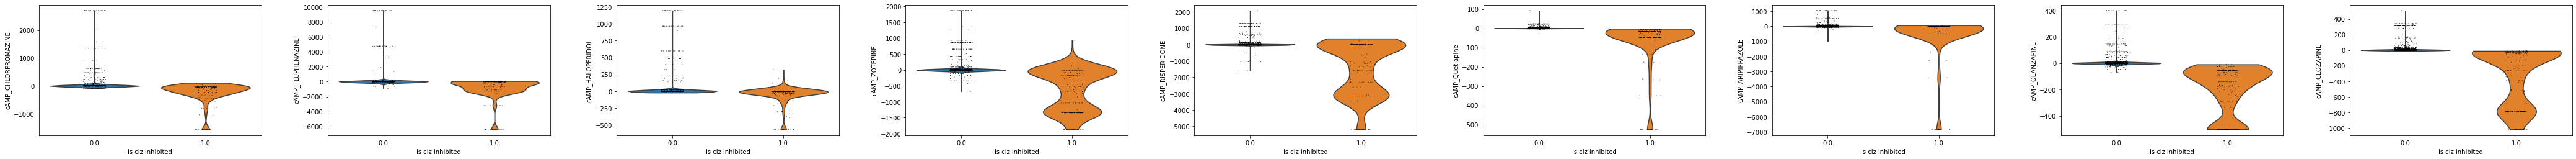

CPU times: user 1.03 s, sys: 31.3 ms, total: 1.06 s
Wall time: 1.05 s


In [23]:
%%time
target=["cAMP_%s"%drug for drug in drug_list]
sc.pl.violin(adata, target, groupby='is_clz_inhibited')

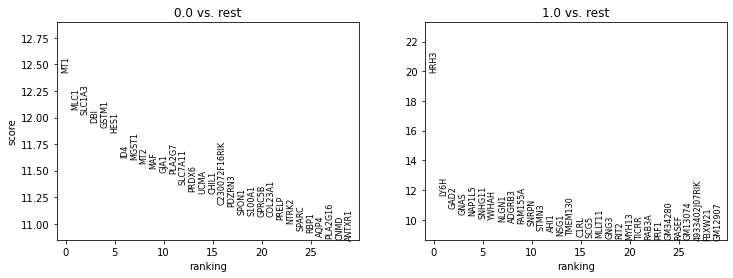

In [52]:
sc.tl.rank_genes_groups(adata, 'is_clz_selective', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=30, sharey=False)

In [79]:
file_path="/temp/data/mouse_SFO/WT_SFO_adata.h5ad"
adata.write(file_path)

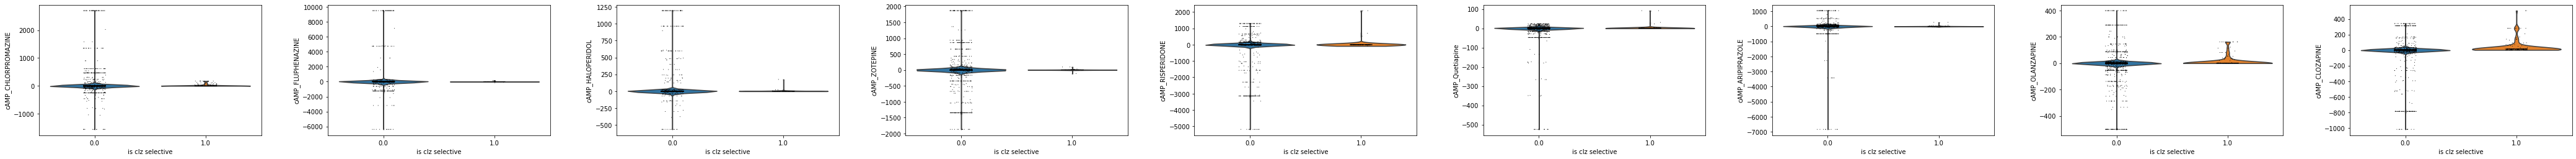

CPU times: user 902 ms, sys: 4.06 ms, total: 906 ms
Wall time: 902 ms


In [24]:
%%time
target=["cAMP_%s"%drug for drug in drug_list]
sc.pl.violin(adata, target, groupby='is_clz_selective')

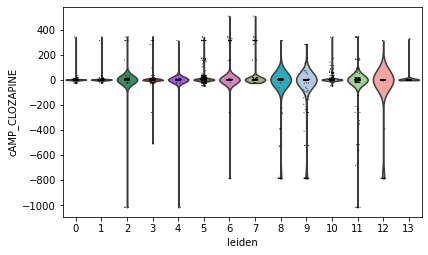

In [56]:
sc.pl.violin(adata, "cAMP_CLOZAPINE", groupby='leiden')

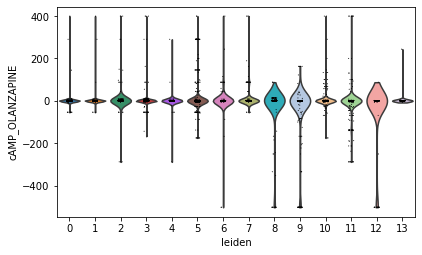

In [57]:
sc.pl.violin(adata, "cAMP_OLANZAPINE", groupby='leiden')

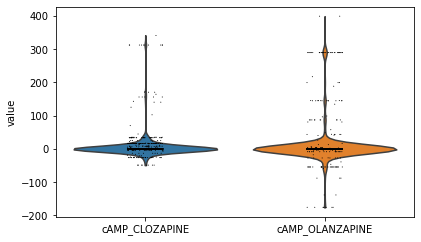

In [63]:
sc.pl.violin(adata[adata.obs["leiden"]==5],[ "cAMP_CLOZAPINE", "cAMP_OLANZAPINE"])

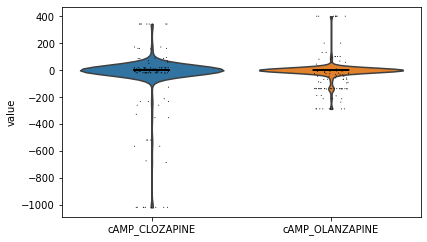

In [64]:
sc.pl.violin(adata[adata.obs["leiden"]==11],[ "cAMP_CLOZAPINE", "cAMP_OLANZAPINE"])

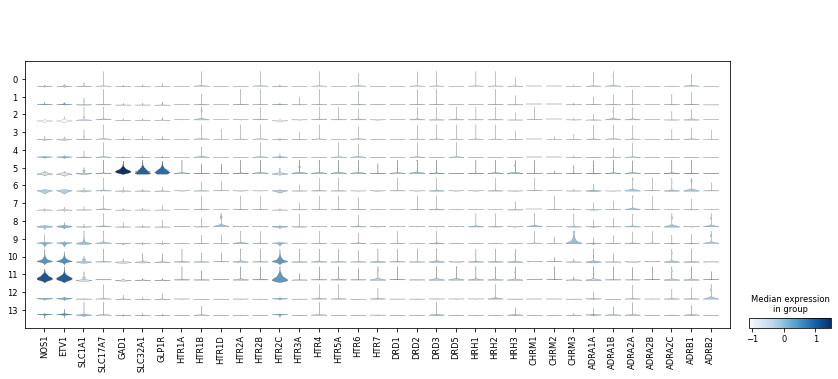

In [58]:
sc.pl.stacked_violin(adata, markers, groupby='leiden', rotation=90)